In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

In [2]:
# 1. Load and Prepare Dataset
data = datasets.load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [4]:
# PCA for 2D projection
pca = PCA(n_components=2)
X_train_2D = pca.fit_transform(X_train_scaled)
X_test_2D = pca.transform(X_test_scaled)

In [5]:
# Helper to plot decision boundary
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(7,5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='coolwarm', s=40, edgecolor='k')
    plt.title(title)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.grid(True)
    plt.show()

In [6]:
# 2. Train SVMs
svm_linear = SVC(kernel='linear', C=1)
svm_linear.fit(X_train_2D, y_train)

svm_rbf = SVC(kernel='rbf', C=1, gamma=0.1)
svm_rbf.fit(X_train_2D, y_train)

SVC(C=1, gamma=0.1)

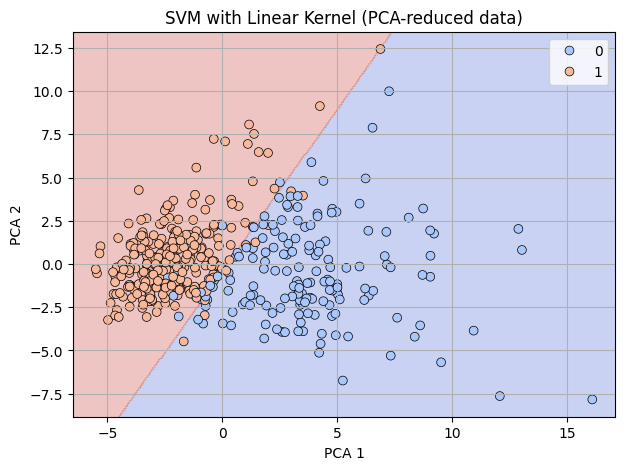

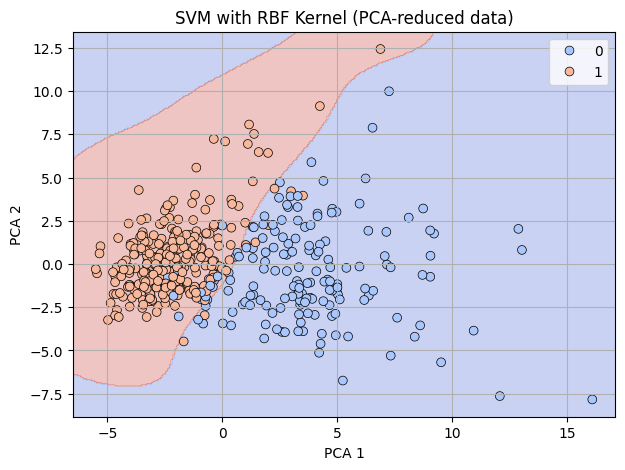

In [7]:
# 3. Visualize Decision Boundaries
plot_decision_boundary(svm_linear, X_train_2D, y_train, 'SVM with Linear Kernel (PCA-reduced data)')
plot_decision_boundary(svm_rbf, X_train_2D, y_train, 'SVM with RBF Kernel (PCA-reduced data)')


In [9]:
# 4. Hyperparameter Tuning with Grid Search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1]
}
grid = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_scaled, y_train)
print("Best parameters from GridSearchCV:", grid.best_params_)

Best parameters from GridSearchCV: {'C': 100, 'gamma': 0.001}


In [10]:
# 5. Cross-validation
cv_scores = cross_val_score(grid.best_estimator_, X_train_scaled, y_train, cv=10)
print("Cross-validation Accuracy: %.2f%% ± %.2f%%" % (cv_scores.mean()*100, cv_scores.std()*100))


Cross-validation Accuracy: 97.36% ± 2.17%



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        43
           1       0.97      1.00      0.99        71

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



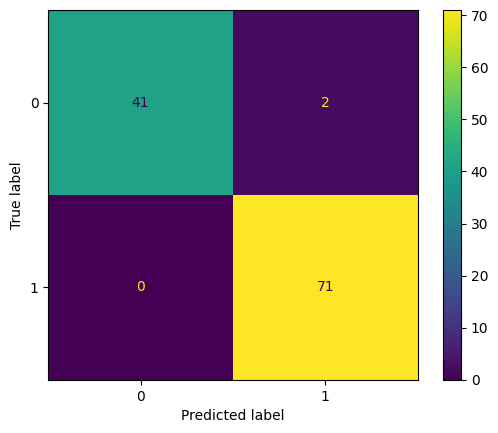

In [11]:
# Evaluation on test set
y_pred = grid.best_estimator_.predict(X_test_scaled)
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(grid.best_estimator_, X_test_scaled, y_test)
plt.show()

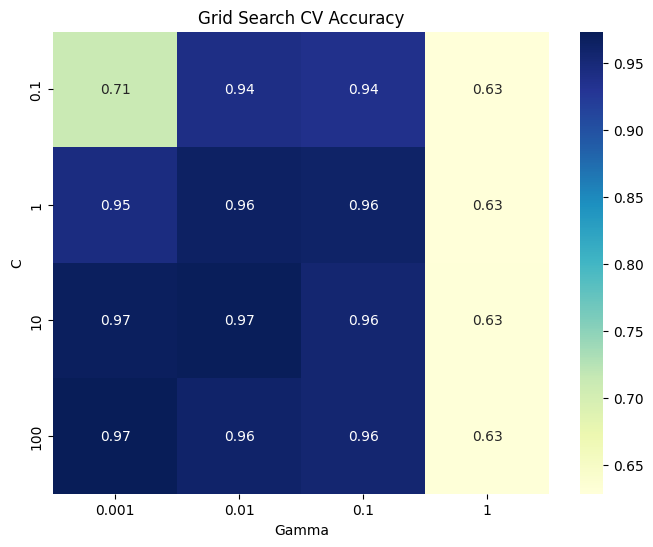

In [12]:
# BONUS: Heatmap of cross-validation scores
results = grid.cv_results_
scores = results['mean_test_score'].reshape(len(param_grid['C']), len(param_grid['gamma']))

plt.figure(figsize=(8,6))
sns.heatmap(scores, annot=True, xticklabels=param_grid['gamma'], yticklabels=param_grid['C'], cmap="YlGnBu")
plt.title("Grid Search CV Accuracy")
plt.xlabel("Gamma")
plt.ylabel("C")
plt.show()